# 1. Import Libraries

In [79]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
!pip install mediapipe
import mediapipe as mp
import shutil
from tqdm import tqdm

# Import Videos Dataset

#2. Convert videos (dataset) into keypoints frames

In [3]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [ ]:
os.mkdir('MP_Data')
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array([name for name in os.listdir("dataset")])
actions = np.sort(actions)

# Number of frames per any single video
sequence_length = 40

In [ ]:
#create folders to hold dataset of np arrays; subfolder for each class/word
for action in actions: 
    os.mkdir('MP_Data/'+action)
    
    file_names = os.listdir("dataset/"+action)
    file_names = [int(x[:-4]) for x in file_names]
    num_of_vids = max(file_names)
    for i in range(0,num_of_vids+1):
        os.mkdir('MP_Data/'+action+"/"+str(i))

In [ ]:
# Create detections of pose and hands in npy format

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose,lh, rh])

# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    # Loop through actions
    for action in tqdm(actions):
        
        file_names = os.listdir("dataset/"+action)
        file_names = [int(x[:-4]) for x in file_names]
        num_of_vids = max(file_names)
        
        # Loop through sequences aka videos
        for sequence in range(0, num_of_vids+1):
            
            vidcap = cv2.VideoCapture('dataset/{}/{}.mp4'.format(action,sequence))
            success,frame = vidcap.read()
            count = -1
            # Loop through each frame
            while success:  
                count += 1

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
                
                # Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(count))
                np.save(npy_path, keypoints)
                success,frame = vidcap.read()

100%|███████████████████████████████████████████████████████████████████████████████| 52/52 [3:43:22<00:00, 257.75s/it]


#3. Filter videos to select 20 frame out of 40
using action detection algorithm

In [ ]:
#SETUP FOLDERS FOR FILTERED DATA
os.mkdir('MP_Data_FILTERED')
DATA_PATH = os.path.join('MP_Data_FILTERED') 
actions = np.array([name for name in os.listdir("dataset")])
actions = np.sort(actions)
sequence_length = 20
number_of_frames = 20

In [ ]:
#create folders to hold dataset of np arrays
for action in actions: 
    os.mkdir('MP_Data_FILTERED/'+action)
    file_names = os.listdir("dataset/"+action)
    file_names = [int(x[:-4]) for x in file_names]
    num_of_vids = max(file_names)
    for i in range(0,num_of_vids+1):
        os.mkdir('MP_Data_FILTERED/'+action+"/"+str(i))

In [ ]:
# DO THE PROCESS

# Loop through actions (words)
for action in tqdm(actions):
    file_names = os.listdir("dataset/"+action)
    file_names = [int(x[:-4]) for x in file_names]
    num_of_vids = max(file_names)
    # Loop through sequences (videos)
    for sequence in range(0, num_of_vids+1):
        vidcap = cv2.VideoCapture('dataset/{}/{}.mp4'.format(action,sequence))
        success,frameTemp = vidcap.read() #FRAME IS IMAGE
        success,frame = vidcap.read() 
        count = -1
        actionMagnitude = []
        # Loop through each frame in a single video, to find the action magnitude over each frame in a video
        while success:
            count += 1
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            gray = cv2.GaussianBlur(gray, (21, 21), 0)
            static_back = cv2.cvtColor(frameTemp, cv2.COLOR_BGR2GRAY)
            static_back = cv2.GaussianBlur(static_back, (21, 21), 0)
            diff_frame = cv2.absdiff(static_back, gray)
            actionMagnitude.append(diff_frame.sum())
            frameTemp = np.copy(frame)
            success,frame = vidcap.read() #FRAME IS IMAGE

        #find best n frames to extract************************************
        maxIndex = 0 #best index to start collecting max(n = 20) frame. ex: max=5 means best is to collect frames[5:25]
        maxMagnitude = 0 #for a given number_of_frames
        for i in range(0,len(actionMagnitude)-number_of_frames):
            if sum(actionMagnitude[i:i+number_of_frames]) > maxMagnitude:
                maxIndex = i
                maxMagnitude = sum(actionMagnitude[i:i+number_of_frames])

        #Copy selected frames' keypoints into another location************
        for i in range(maxIndex,maxIndex+number_of_frames):
            source = "MP_Data/{}/{}/{}.npy".format(action,sequence,i)
            destination = "MP_Data_FILTERED/{}/{}/{}.npy".format(action,sequence,i-maxIndex) #renamed to be all starting from 0
            shutil.copyfile(source, destination)

100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [28:21<00:00, 32.72s/it]


# 4. Load data into Model

In [80]:
actions = np.array([name for name in os.listdir("MP_Data_FILTERED")])
actions = np.sort(actions)
sequence_length = 20
label_map = {label:num for num, label in enumerate(actions)}
DATA_PATH = os.path.join('MP_Data_FILTERED') 

In [5]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])
print('Data loaded!\ndata size: ',np.array(sequences).shape)
print('labels size: ',np.array(labels).shape)


Data loaded!
data size:  (3426, 20, 258)
labels size:  (3426,)


In [6]:
res.shape

(258,)

In [72]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

X = np.array(sequences)
y = to_categorical(labels).astype(int)

#DO FLIP HORIZONTAL ON ALL (DATA AUGMENTATION)
X = np.concatenate([X,X*-1])
y = np.concatenate([y,y])
#*********************************************

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42, shuffle=True)

print('Test       : ',y_test.shape)
print('Validation : ',y_val.shape)
print('Train      : ',y_train.shape)

Test       :  (686, 52)
Validation :  (617, 52)
Train      :  (5549, 52)


# 5. Modeling

In [81]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

model = Sequential()

model.add(Bidirectional(LSTM(128, return_sequences=True, activation='tanh', input_shape=(np.array(sequences).shape[1],np.array(sequences).shape[2]))))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(128, return_sequences=True, activation='tanh')))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(256, return_sequences=False, activation='tanh')))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(128, activation='tanh'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(actions.shape[0], activation='softmax'))

model.compile(optimizer='Adam',  loss='categorical_crossentropy', metrics=['categorical_accuracy'])

checkpoint = ModelCheckpoint('weights.hdf5',monitor='val_categorical_accuracy',save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', patience=60)
earlystoppingmonitor =  EarlyStopping(monitor='val_categorical_accuracy',patience=130)

training = model.fit(X_train, y_train,  batch_size=512, epochs=600,validation_data=(X_val,y_val),
         callbacks=[checkpoint,earlystoppingmonitor,reduce_lr,tb_callback])

In [82]:
from tensorflow.keras.models import load_model
model = load_model('final.keras')

In [83]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 20, 256)           396288    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 20, 256)           0         
                                                                 
 batch_normalization (Batch  (None, 20, 256)           1024      
 Normalization)                                                  
                                                                 
 bidirectional_1 (Bidirecti  (None, 20, 256)           394240    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 20, 256)           0         
                                                        

# 6. Testing and Evaluating

## 6.1 Using Cross Validation (Using Accuracy)

In [88]:
from tensorflow.keras.models import load_model
from sklearn.metrics import  accuracy_score

#using the model checkpoint
best = load_model('weights.hdf5')
yhat = best.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
print("Testing Accuracy (Checkpoint): ",accuracy_score(ytrue, yhat))

#using the full trained model (till last executed epoch)
yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
print("Testing Accuracy: ",accuracy_score(ytrue, yhat))

22/22 [==============================] - 3s 47ms/step
Testing Accuracy (Checkpoint):  0.9475218658892128
22/22 [==============================] - 1s 49ms/step
Testing Accuracy:  0.9460641399416909


In [89]:
#using the model checkpoint
best = load_model('weights.hdf5')
yhat = best.predict(X_val)
ytrue = np.argmax(y_val, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
print("Val Accuracy (Checkpoint): ",accuracy_score(ytrue, yhat))

yhat = best.predict(X_train)
ytrue = np.argmax(y_train, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
print("Train Accuracy (Checkpoint): ",accuracy_score(ytrue, yhat))

20/20 [==============================] - 4s 48ms/step
Val Accuracy (Checkpoint):  0.940032414910859
174/174 [==============================] - 9s 51ms/step
Train Accuracy (Checkpoint):  1.0


## 6.2 Using Confusion Matrix

22/22 [==============================] - 1s 34ms/step


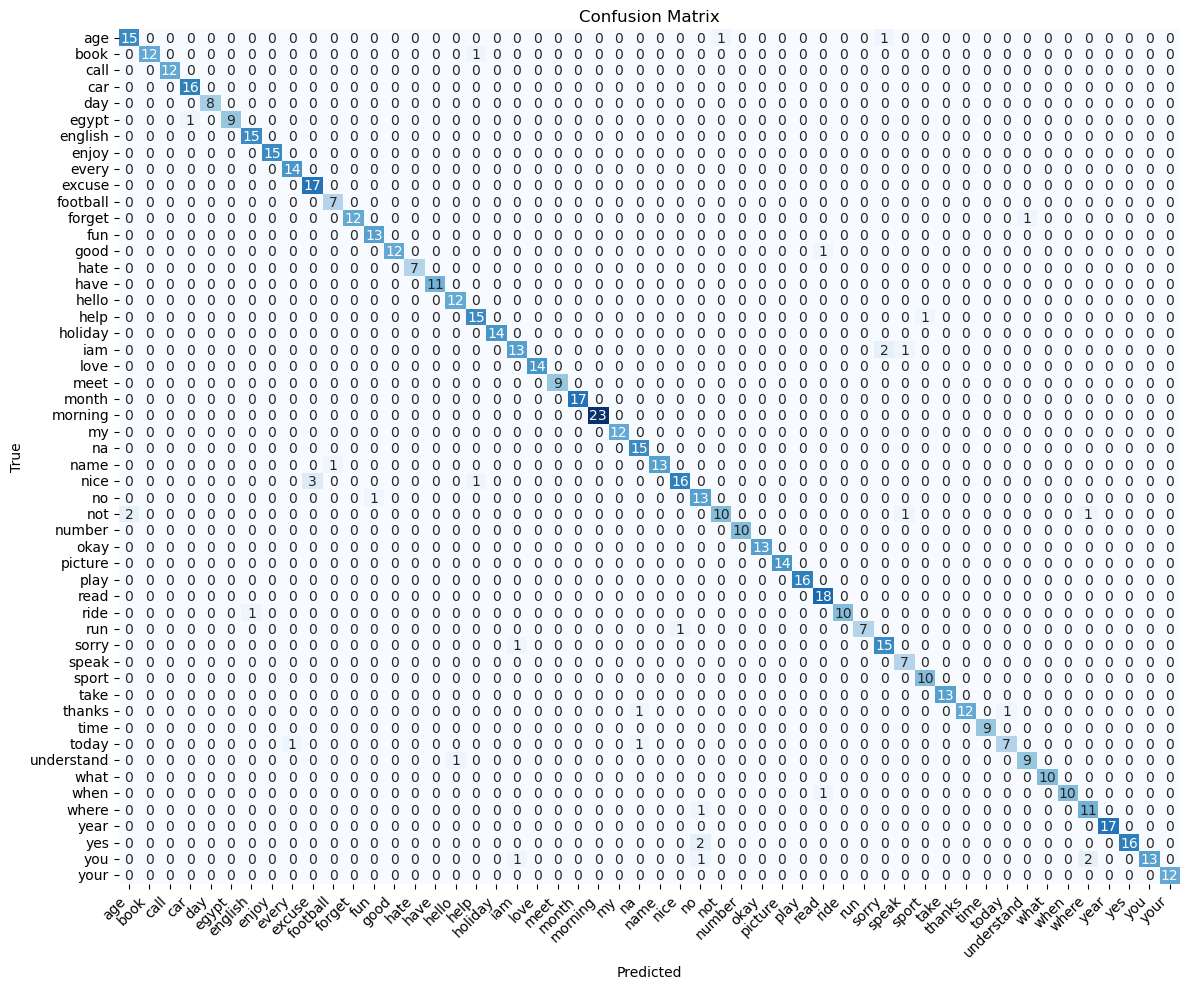

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion matrix calculation
y_pred = best.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

# Plotting confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=actions, yticklabels=actions)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## 6.3 Using Other Metrics (Precision, Recall, F1 Score)

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate metrics
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Precision: 0.9518898694945075
Recall: 0.9501706956316684
F1-score: 0.9487602247445689


# 7. Save Model

In [28]:
model.save('final.keras')

# 8.Testing in Real time

In [76]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [64]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [65]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [66]:
def draw_styled_landmarks(image, results):
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [67]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, lh, rh])

In [42]:
from PIL import ImageFont, ImageDraw, Image
import arabic_reshaper
from bidi.algorithm import get_display

In [87]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5
prediction=0
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        print(keypoints.shape)
        sequence.append(keypoints)
        sequence = sequence[-20:]
        
        if len(sequence) == 20:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            prediction=actions[np.argmax(res)]
            print(prediction)
            predictions.append(np.argmax(res))
            

            # Specify the font .ttf file
            fontpath = "C:\\Users\\Yehia\\Arabic-Sign-Language-Detection\\Amiri-BoldItalic.ttf"

            # Set the font size and color
            font = ImageFont.truetype(fontpath, 32)
            color = (255, 255, 255)  # white color

            # Convert the image to a PIL Image
            img_pil = Image.fromarray(image)

            # Create a draw object
            draw = ImageDraw.Draw(img_pil)

            # Position where you want to put the text
            position = (40, 40)

            
            reshaped_text = arabic_reshaper.reshape(prediction)
            bidi_text = get_display(reshaped_text)

                # Calculate the position for each word
            x = position[0]
            y = position[1]  # Increment y-coordinate for each word

                # Draw the text on the image
            draw.text((x, y), bidi_text, font=font, fill=color)
            # Convert back to OpenCV image and save/show
            image = np.array(img_pil)
           

        # Show to screen
        cv2.imshow('OpenCV Feed', image)
    

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
(258,)
<class 'mediapipe.python.solution_base.SolutionOutputs'>
(258,)
<class 'mediapipe.python.solution_base.SolutionOutputs'>
(258,)
<class 'mediapipe.python.solution_base.SolutionOutputs'>
(258,)
<class 'mediapipe.python.solution_base.SolutionOutputs'>
(258,)
<class 'mediapipe.python.solution_base.SolutionOutputs'>
(258,)
<class 'mediapipe.python.solution_base.SolutionOutputs'>
(258,)
<class 'mediapipe.python.solution_base.SolutionOutputs'>
(258,)
<class 'mediapipe.python.solution_base.SolutionOutputs'>
(258,)
<class 'mediapipe.python.solution_base.SolutionOutputs'>
(258,)
<class 'mediapipe.python.solution_base.SolutionOutputs'>
(258,)
<class 'mediapipe.python.solution_base.SolutionOutputs'>
(258,)
<class 'mediapipe.python.solution_base.SolutionOutputs'>
(258,)
<class 'mediapipe.python.solution_base.SolutionOutputs'>
(258,)
<class 'mediapipe.python.solution_base.SolutionOutputs'>
(258,)
<class 'mediapipe.python.solution_base.S